# Really Fancy Skew-T
This example combines a Skew-T and a hodograph using GridSpec from Matplotlib as well as calculating 
a smorgasbord of different convective parameters and indices using functions from metpy.calc and metpy.indices to showcase metpy's new CAPE-abilities.

In [51]:
from matplotlib.axes import Axes
import matplotlib.axis as maxis
from matplotlib.projections import register_projection
import matplotlib.spines as mspines
from matplotlib.ticker import MultipleLocator, NullFormatter, ScalarFormatter
import matplotlib.transforms as transforms
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt

from metpy.calc import (dewpoint, dry_lapse, moist_lapse, vapor_pressure, saturation_vapor_pressure,
                        get_wind_speed, get_wind_dir, mixing_ratio, cape_cin, get_wind_components,
                        equivalent_potential_temperature, parcel_profile, precipitable_water)
from metpy.calc.tools import delete_masked_points, log_interp, get_layer
from metpy.units import units
from metpy.plots import SkewT
from metpy.plots import Hodograph
from metpy.units import concatenate
from metpy.constants import Rd
import metpy.calc as metcalc

import numpy.ma as ma
from netCDF4 import Dataset
import netCDF4
from netCDF4 import num2date, date2num
from datetime import datetime
import math

#sounding = np.genfromtxt("testsounding.txt", usecols = (0, 2, 3, 6, 7, 1))
from datetime import datetime
from metpy.io import get_upper_air_data

In [52]:
def bunkers_storm_motion(u, v, p, hgt, interp=False):

    r"""Calculate the Bunkers RM and LM storm motions, as 
    well as the mean sfc-6km flow for ordinary cell motion.
    Uses the storm motion calculation from [Bunkers et al, 2000],
    which does not require effective inflow layer calculations,
    unlike the more recent version in [Bunkers et al 2014].
    
    Parameters
    ----------
    u : array-like
        U component of the wind
    v : array-like
        V component of the wind
    p : array-like
        Pressure from sounding
    hgt : array-like
        Heights from sounding
    
    Returns
    -------
    RM_vector
        U and v component of Bunkers RM storm motion
    LM_vector
        U and v component of Bunkers LM storm motion
    mean_vector
        U and v component of sfc-6km mean flow
        
    See Also
    --------
    bunkers_storm_motion_2014
    
    Citations:
    
    Bunkers, M. J., B. A. Klimowski, J. W. Zeitler, R. L. Thompson, and M. L. Weisman, 2000:
        Predicting supercell motion using a new hodograph technique. Wea. Forecasting, 15, 61–79.
    
    
    Bunkers, M. J., D. A. Barber, R. L. Thompson, R. Edwards, and J. Garner, 2014: 
        Choosing a universal mean wind for supercell motion prediction. J. Operational Meteor.,
        2 (11), 115–129, doi: https://dx.doi.org/10.15191/nwajom.2014.0211.
    
    
     """

    u = u.to('m/s')
    v = v.to('m/s')
    
    if interp:
        
        dp = -1
        pressure_top = np.interp(6000, hgt.magnitude - hgt[0].magnitude, np.log(p.magnitude))
        pressure_top = np.exp(pressure_top)
        interp_levels = (np.arange(p[0].magnitude, pressure_top + dp, dp)) * units('hPa')
        u = log_interp(interp_levels, p, u)
        v = log_interp(interp_levels, p, v)
        hgt = log_interp(interp_levels, p, hgt)
        p = interp_levels
    
    #mean wind from sfc-6km
    #correct height to be height AGL
    u6 = mean_wind_pressure_weighted(u, v, p, hgt, top = 6000 * units('meter'))
    u6m = u6[0]
    v6m = u6[1]

    #mean wind from sfc-500m

    u5 = mean_wind_pressure_weighted(u, v, p, hgt, top = 500 * units('meter'))
    u5m = u5[0]
    v5m = u5[1]

    #mean wind from 5.5-6km

    u55 = mean_wind_pressure_weighted(u, v, p, hgt, top = 6000 * units('meter'), bottom = 5500 * units('meter'))
    u55m = u55[0]
    v55m = u55[1]

    #Calculate the shear vector from sfc-500m to 5.5-6km

    u6shr = u55m - u5m
    v6shr = v55m - v5m

    #making the shear vector

    vl = [u6shr.magnitude, v6shr.magnitude, 0]

    #Create a k hat vector

    vk = [0,0,1]

    #Take the cross product of the wind shear and k, and divide by the vector magnitude and multiply by D (7.5 m/s or 14.5788 kt)
    rdev = np.cross(vl, vk)*(7.5/(np.sqrt(u6shr.magnitude ** 2 + v6shr.magnitude ** 2)))
    ldev = np.cross(vk, vl)*(7.5/(np.sqrt(u6shr.magnitude ** 2 + v6shr.magnitude ** 2)))
    
    #Add the deviations to the layer average wind to get the RM motion
    uRM = u6m.magnitude + rdev[0]
    vRM = v6m.magnitude + rdev[1]

    #Subtract the deviations to get the LM motion
    uLM = u6m.magnitude - rdev[0]
    vLM = v6m.magnitude - rdev[1]
    
    RM_vector = np.asarray([uRM, vRM])*units('m/s')
    
    LM_vector = np.asarray([uLM, vLM])*units('m/s')
    
    mean_vector = np.asarray([u6m.magnitude, v6m.magnitude])*units('m/s')
    
    return RM_vector, LM_vector, mean_vector


In [53]:
def most_unstable_parcel(p, temperature, dewpoint, heights=None,
                         bottom=None, depth=300 * units.hPa):
    """
    Determine the most unstable parcel in a layer.
    Determines the most unstable parcle of air by calculating the equivalent
    potential temperature and finding its maximum in the specified layer.
    Parameters
    ----------
    p: `pint.Quantity`
        Atmospheric pressure profile
    temperature: `pint.Quantity`
        Atmospheric temperature profile
    dewpoint: `pint.Quantity`
        Atmospheric dewpoint profile
    heights: `pint.Quantity`
        Atmospheric height profile. Standard atmosphere assumed when None.
    bottom: `pint.Quantity`
        Bottom of the layer to consider for the calculation in pressure or height
    depth: `pint.Quantity`
        Depth of the layer to consider for the calculation in pressure or height
    Returns
    -------
    `pint.Quantity`
        Pressure, temperature, and dew point of most unstable parcel in the profile.
    See Also
    --------
    get_layer
    """
    p_layer, T_layer, Td_layer = get_layer(p, temperature, dewpoint, bottom=bottom,
                                           depth=depth, heights=heights)
    theta_e = equivalent_potential_temperature(p_layer, T_layer)
    max_idx = np.argmax(theta_e)
    return p_layer[max_idx], T_layer[max_idx], Td_layer[max_idx], max_idx


In [54]:
def mucape_mucin(pressure, temperature, dewpoint, **kwargs):
    r"""Calculate MUCAPE and MUCIN.
    Calculate the convective available potential energy (CAPE) and convective inhibition (CIN)
    of a given upper air profile and most unstable parcel path. CIN is integrated between the
    surface and LFC, CAPE is integrated between the LFC and EL (or top of sounding).
    Intersection points of the measured temperature profile and parcel profile are linearly
    interpolated.
    Parameters
    ----------
    pressure : `pint.Quantity`
        The atmospheric pressure level(s) of interest. The first entry should be the starting
        point pressure.
    temperature : `pint.Quantity`
        The sounding temperature
    dewpoint : `pint.Quantity`
        The starting dew point
    Returns
    -------
    `pint.Quantity`
        Convective available potential energy (CAPE) for the most unstable parcel.
    `pint.Quantity`
        Convective inhibition (CIN) for the most unstable parcel.
    Notes
    -----
    Formula adopted from [Hobbs1977]_.
    .. math:: \text{CAPE} = -R_d \int_{LFC}^{EL} (T_{parcel} - T_{env}) d\text{ln}(p)
    .. math:: \text{CIN} = -R_d \int_{SFC}^{LFC} (T_{parcel} - T_{env}) d\text{ln}(p)
    * :math:`CAPE` Convective available potential energy
    * :math:`CIN` Convective inhibition
    * :math:`LFC` Pressure of the level of free convection
    * :math:`EL` Pressure of the equilibrium level
    * :math:`SFC` Level of the surface or beginning of parcel path
    * :math:`R_d` Gas constant
    * :math:`g` Gravitational acceleration
    * :math:`T_{parcel}` Parcel temperature
    * :math:`T_{env}` Environment temperature
    * :math:`p` Atmospheric pressure
    See Also
    --------
    lfc, el
    """
    parcel = most_unstable_parcel(pressure, temperature, dewpoint, **kwargs)
    pres = pressure[parcel[-1]:]
    temp = temperature[parcel[-1]:]
    mu_profile = parcel_profile(pres, parcel[1], parcel[2]).to('degC')
    return cape_cin(pres, temp, dewpoint, mu_profile)

In [55]:
def storm_relative_helicity(u, v, p, hgt, top, bottom=None,
                            storm_u=0 * units('m/s'), storm_v=0 * units('m/s')):
    # Partially adapted from similar SharpPy code
    r"""Calculate Storm Relative Helicity.
    Needs u and v wind components, heights and pressures,
    and top and bottom of SRH layer. An optional storm
    motion vector can be specified.
    Parameters
    ----------
    u : array-like
        The u components of winds, same length as hgts
    v : array-like
        The u components of winds, same length as hgts
    p : array-like
        Pressure in hPa, same length as hgts
    hgts : array-like
        The heights associatd with the data, provided in meters above mean
        sea level and converted into meters AGL.
    top : number
        The height of the top of the desired layer for SRH.
    bottom : number
        The height at the bottom of the SRH layer. Default is sfc (None).
    storm_u : number
        u component of storm motion
    storm_v : number
        v component of storm motion

    Returns
    -------
    number
        p_srh : positive storm-relative helicity
    number
        n_srh : negative storm-relative helicity
    number
        t_srh : total storm-relative helicity
    """
    u = u.to('meters/second')
    v = v.to('meters/second')
    storm_u = storm_u.to('meters/second')
    storm_v = storm_v.to('meters/second')
    
    if bottom:
        depth_s = top - bottom
    else:
        depth_s = top

    w_int = get_layer(p, u, v, heights=hgt, bottom=bottom, depth=depth_s)
    
    sru = (w_int[1] - storm_u)
    srv = (w_int[2] - storm_v)

    int_layers = (sru[1:] * srv[:-1] - sru[:-1] * srv[1:])

    p_srh = int_layers[int_layers.magnitude > 0.].sum()
    n_srh = int_layers[int_layers.magnitude < 0.].sum()
    t_srh = p_srh + n_srh

    return p_srh, n_srh, t_srh

In [56]:
def bulk_shear(u, v, p, hgt, top, bottom = None):
    r"""Calculate bulk shear through a layer. 
    
    Layer top and bottom specified in meters AGL:
    
    Parameters
    ----------
    u : array-like
        U-component of wind.
    v : array-like
        V-component of wind.
    p : array-like
        Atmospheric pressure profile
    hgt : array-like
        Heights from sounding
    top: `pint.Quantity`
        The top of the layer in meters AGL
    bottom: `pint.Quantity`
        The bottom of the layer in meters AGL.
        Default is the surface.
        
    Returns
    -------
    `pint.Quantity'
        u_shr: u-component of layer bulk shear, in m/s
    `pint.Quantity'
        v_shr: v-component of layer bulk shear, in m/s
    `pint.Quantity'
        shr_mag: magnitude of layer bulk shear, in m/s
        
    """   
    if bottom:
        depth_s = top - bottom
    else:
        depth_s = top
    
    u = u.to('meters/second')
    v = v.to('meters/second')
    
    w_int = get_layer(p, u, v, heights=hgt, bottom=bottom, depth=depth_s)
    
    u_shr = w_int[1][-1] - w_int[1][0]
    v_shr = w_int[2][-1] - w_int[2][0]
    
    shr_mag = np.sqrt((u_shr ** 2) + (v_shr ** 2))
    
    return u_shr, v_shr, shr_mag

    

In [57]:
#Supercell composite calculation. Should use mucape, esrh, and ebwd, but for now we'll use sbcape, sfc-3 srh, and sfc-6 shear
def supercell_comp(mucape, esrh, ebwd):
    r"""Calculate the supercell composite parameter.
     
    The supercell composite parameter is designed to identify
    environments favorable for the development of supercells,
    and is calculated using the formula developed by 
    [Thompson, Edwards, and Mead, 2004]:
    
    SCP = (mucape / 1000 J/kg) * (esrh / 50 m^2/s^2) * (ebwd / 20 m/s) 
    
    The ebwd term is set to zero below 10 m/s and
    capped at 1 when ebwd exceeds 20 m/s.
    
    Parameters
    ----------
    mucape : array-like
        Most-unstable CAPE
    esrh : array-like
        Effective-layer storm-relative helicity
    ebwd : array-like
        Effective bulk shear
        
    Returns
    -------
    number
        supercell composite
        
    Citation:
    Thompson, R.L., R. Edwards, and C. M. Mead, 2004b:
        An update to the supercell composite
        and significant tornado parameters.
        Preprints, 22nd Conf. on Severe Local
        Storms, Hyannis, MA, Amer.
        Meteor. Soc.
        
    """
    
    ebwd = ebwd.to('m/s')
    ebwd = ebwd.magnitude
    inds = np.where((ebwd <= 20.) & (ebwd >= 10.))
    inds1 = np.where(ebwd < 10.)
    inds2 = np.where(ebwd > 20.)
    ebwd[inds] = ebwd[inds] / 20.
    ebwd[inds1] = 0.
    ebwd[inds2] = 1.
    sup_comp = (mucape.magnitude / 1000.) * (esrh.magnitude / 50.) * ebwd
     
    return sup_comp

In [58]:
def sigtor(sbcape, sblcl, srh1, shr6):
    r"""Calculate the significant tornado parameter (fixed layer).
     
    The significant tornado parameter is designed to identify
    environments favorable for the production of significant
    tornadoes contingent upon the development of supercells.
    It's calculated according to the formula used on the SPC
    mesoanalysis page, updated in [Thompson, Edwards, and Mead, 2004]:
    
    sigtor = (sbcape / 1500 J/kg) * ((2000 m - sblcl) / 1000 m) * (srh1 / 150 m^s/s^2) * (shr6 / 20 m/s)
    
    The sblcl term is set to zero when the lcl is above 2000m and 
    capped at 1 when below 1000m, and the shr6 term is set to 0 
    when shr6 is below 12.5 m/s and maxed out at 1.5 when shr6
    exceeds 30 m/s.
    
    Parameters
    ----------
    sbcape : array-like
        Surface-based CAPE
    sblcl : array-like
        Surface-based lifted condensation level
    srh1 : array-like
        Surface-1km storm-relative helicity
    shr6 : array-like
        Surface-6km bulk shear
        
    Returns
    -------
    number
        significant tornado parameter
    
    Citation:
    Thompson, R.L., R. Edwards, and C. M. Mead, 2004b:
        An update to the supercell composite
        and significant tornado parameters.
        Preprints, 22nd Conf. on Severe Local
        Storms, Hyannis, MA, Amer.
        Meteor. Soc.
        
    """
    
    shr6 = shr6.to('m/s')
    shr6 = shr6.magnitude
    sblcl = sblcl.magnitude
    ind = np.where((sblcl <= 2000.) & (sblcl >= 1000.))
    ind1 = np.where(sblcl < 1000.)
    ind2 = np.where(sblcl > 2000.)
    sind = np.where((shr6 <= 30.) & (shr6 >= 12.5))
    sind1 = np.where(shr6 < 12.5)
    sind2 = np.where(shr6 > 30.)
    sblcl[ind] = (2000. - sblcl[ind]) / 1000.
    sblcl[ind1] = 1.
    sblcl[ind2] = 0.
    shr6[sind] = shr6[sind] / 20.
    shr6[sind1] = 0.
    shr6[sind2] = 1.5
    sigtor = (sbcape.magnitude / 1500.) * sblcl * (srh1.magnitude / 150.) * shr6
     
    return sigtor

In [59]:
def mean_wind_pressure_weighted(u, v, p, hgt, top, bottom=None, interp=False):
    
    u = u.to('meters/second')
    v = v.to('meters/second')
    
    if bottom:
        depth_s = top - bottom
        bottom = bottom + hgt[0]
    else:
        depth_s = top
        
    if interp:
        dp = -1
        pressure_top = np.interp(top.magnitude, hgt.magnitude - hgt[0].magnitude, np.log(p.magnitude))
        pressure_top = np.exp(pressure_top)
        interp_levels = (np.arange(p[0].magnitude, pressure_top + dp, dp)) * units('hPa')
        u_int = log_interp(interp_levels, p, u)
        v_int = log_interp(interp_levels, p, v)
        h_int = log_interp(interp_levels, p, hgt)
        w_int = get_layer(interp_levels, u_int, v_int, heights=h_int, bottom=bottom, depth=depth_s)
    else:
        w_int = get_layer(p, u, v, heights=hgt, bottom=bottom, depth=depth_s)
    
    u_mean = ma.average(w_int[1], weights = w_int[0]) * units('m/s')
    v_mean = ma.average(w_int[2], weights = w_int[0]) * units('m/s')
    
    return u_mean, v_mean

In [61]:
def critical_angle(ushr, vshr, um, vm, usfc, vsfc):
    r"""Calculate the critical angle.
    
    The critical angle is the angle between the 10m storm-relative inflow vector
    and the 10m-500m shear vector. A critical angle near 90 degrees indicates 
    that a storm in this environment on the indicated storm motion vector 
    is likely ingesting purely streamwise vorticity into its updraft, and Esterheld and 
    Giuliana (2008) showed that significantly tornadic supercells tend to occur in environments
    with critical angles near 90 degrees.

    Parameters
    ----------
    
    ushr : array-like
        U-component of 10m-500m shear vector.
    vshr : array-like
        V-component of 10m-500m shear vector.
    um : array-like
        U-component of storm motion.
    vm : array-like
        V-component of storm motion.
    usfc : array-like
        10m wind u component.
    vsfc :
        10m wind v component.
        
    Returns
    -------
    `pint.Quantity'
        critical angle in degrees
        
    
    Esterheld, J., & Giuliano, D. (2008). Discriminating between Tornadic and Non-Tornadic Supercells:
    A New Hodograph Technique. E-Journal Of Severe Storms Meteorology, 3(2).Retrieved July 10, 2017, 
    from http://ejssm.org/ojs/index.php/ejssm/article/view/33/38"""  
    
    #Make everything relative to the sfc wind orientation
    umn = um - usfc
    vmn = vm - vsfc
    
    #Get direction of each vector
    shrdir = get_wind_dir(ushr, vshr)
    smdir = get_wind_dir(umn,vmn)
    #Account for really weird, unlikely storm motions to the SW
    #inds1 = np.where((smdir.magnitude < shrdir.magnitude) & (smdir.magnitude < 90.))
    #print(inds1)
    #print(smdir.shape)
    smdir[(smdir.magnitude < shrdir.magnitude) & (smdir.magnitude < 90.)] = smdir[(smdir.magnitude < shrdir.magnitude) & (smdir.magnitude < 90.)] + (360. * units('degrees')) 
    critical_angle = smdir - shrdir
    return critical_angle

First, let's use the get_upper_air_data function to grab sounding data from the Wyoming sounding archive

In [62]:
date = datetime(2016, 5, 23, 0)
ds = get_upper_air_data(date, 'DDC', region = 'naconf')
#Getting each individual variable
levc = ds.variables['pressure'][:]
hgt = ds.variables['height'][:]
Tc = ds.variables['temperature'][:]
Tdc = ds.variables['dewpoint'][:]
uc = ds.variables['u_wind'][:]
vc = ds.variables['v_wind'][:]

Now calculate some basic sounding levels:

In [63]:
#LCL, LFC, and EL.
LFC_p, LFC_t = metcalc.lfc(levc, Tc, Tdc)
LCL_p, LCL_t = metcalc.lcl(levc[0], Tc[0], Tdc[0])
EL_p, EL_t = metcalc.el(levc, Tc, Tdc)
#Use log_interp to get heights for these
LCL_h = log_interp(LCL_p, levc, hgt)
LFC_h = log_interp(LFC_p, levc, hgt)
EL_h = log_interp(EL_p, levc, hgt)

Next, let's calculate some thermodynamic parameters

In [64]:
#Calculate a parcel profile from the surface
prof = metcalc.parcel_profile(levc, Tc[0], Tdc[0]).to('degC')
#Feed profile into the cape function to get cape and cin
cape, cin = cape_cin(levc, Tc, Tdc, prof)
#Set CAPE to zero if value is nan
if np.isnan(cape):
    cape = 0 * units('J/kg')
#Get most unstable parcel and parcel profile
parcel_mu = most_unstable_parcel(levc, Tc, Tdc)
pres_mu = levc[parcel_mu[-1]:]
#temp_mu = Tc[parcel_mu[-1]:]
mu_profile = parcel_profile(pres_mu, parcel_mu[1], parcel_mu[2]).to('degC')
mucape, mucin = mucape_mucin(levc, Tc, Tdc)
#Set nan mucapes to 0
if np.isnan(mucape):
    mucape = 0 * units('J/kg')
#Get a sfc-3 layer to calculate sfc-3 CAPE from
u3 = get_layer(levc, uc, vc, Tc, Tdc, prof, heights = hgt, depth = 3000 * units('meter'))
#Feed truncated profile into function to get 3km cape and cin
try:
    cape3, cin3 = cape_cin(u3[0], u3[3], u3[4], u3[5])
except:
    cape3 = 0 * units('J/kg')

Now extract some kinematic parameters

In [65]:
#Get Bunkers (2000) storm motions
RM, LM, mean_flow = bunkers_storm_motion(uc, vc, levc, hgt, interp=True)
#Get the speed and direction out of the storm motions for plotting on the sounding later
RM_spd = get_wind_speed(RM[0].to('knots'), RM[1].to('knots'))
RM_dir = get_wind_dir(RM[0], RM[1])
LM_spd = get_wind_speed(LM[0].to('knots'), LM[1].to('knots'))
LM_dir = get_wind_dir(LM[0], LM[1])

#Calculate sfc-3 and sfc-1km helicity
srh3 = storm_relative_helicity(uc, vc, levc, hgt, 3000 * units('meter'), storm_u = RM[0], storm_v = RM[1])
srh1 = storm_relative_helicity(uc, vc, levc, hgt, 1000 * units('meter'), storm_u = RM[0], storm_v = RM[1])
#srh3 = storm_relative_helicity(uc, vc, levc, hgt, 3000 * units('meter'), storm_u = StormU, storm_v = StormV)

#Get sfc-6km and sfc-1km shear
shr6 = bulk_shear(uc, vc, levc, hgt, 6000 * units('meter'))
shr1 = bulk_shear(uc, vc, levc, hgt, 1000 * units('meter'))
shr5 = bulk_shear(uc, vc, levc, hgt, 500 * units('meter'))

#Calculate the critical angle
critical = critical_angle(shr5[0], shr5[1], RM[0], RM[1], uc[0], vc[0])

Calculating some things to plot on the hodograph for reference.

In [66]:
#Getting sfc-3km layer to make an outline of the area swept out for sfc-3km helicity
u3 = get_layer(levc, uc, vc, Tc, Tdc, prof, heights = hgt, depth = 3000 * units('meter'))
uc3 = u3[1]
vc3 = u3[2]
srh_u = np.asarray([uc3[0].magnitude, RM[0].to('knot').magnitude, uc3[-1].magnitude]) * units.knot
srh_v = np.asarray([vc3[0].magnitude, RM[1].to('knot').magnitude, vc3[-1].magnitude]) * units.knot
#Getting a sfc-500m layer to plot the sfc-500m shear vector and the critical angle
u500 = get_layer(levc, uc, vc, heights = hgt, depth = 500 * units('meter'))
uc500 = u500[1]
vc500 = u500[2]
#Get sfc-500m shear vector
us500 = uc500[[0,-1]]
vs500 = vc500[[0,-1]]

Finally, calculate other derived indices

In [67]:
#Technically, supercell composite takes effective layer srh and effective bulk wind difference, but
#since the effective layer function is still a bit dicey we'll use sfc-3km srh and sfc-6km shear as proxies for the 
#moment
sup_comp = supercell_comp(np.asarray([mucape.magnitude]) * units('J/kg'), np.asarray([srh3[0].magnitude]) * units('m^2/s^2'),
                          np.asarray([shr6[2].magnitude]) * units('m/s'))

sigtor_p = sigtor(np.asarray([cape.magnitude]) * units('J/kg'), np.asarray([LCL_h.magnitude-hgt[0].magnitude]) * units('meter'),
                  np.asarray([srh1[0].magnitude]) * units('m^2/s^2'), np.asarray([shr6[2].magnitude]) * units('m/s'))

#eff_layer = get_layer(levc, Tc, Tdc, depth = levc[0] - 400 * units('hPa'))
#bottom_eff, top_eff = effective_layer(levc, Tc, Tdc)

pwat = precipitable_water(Tdc, levc).to('inches')

Now let's actually plot our sounding.

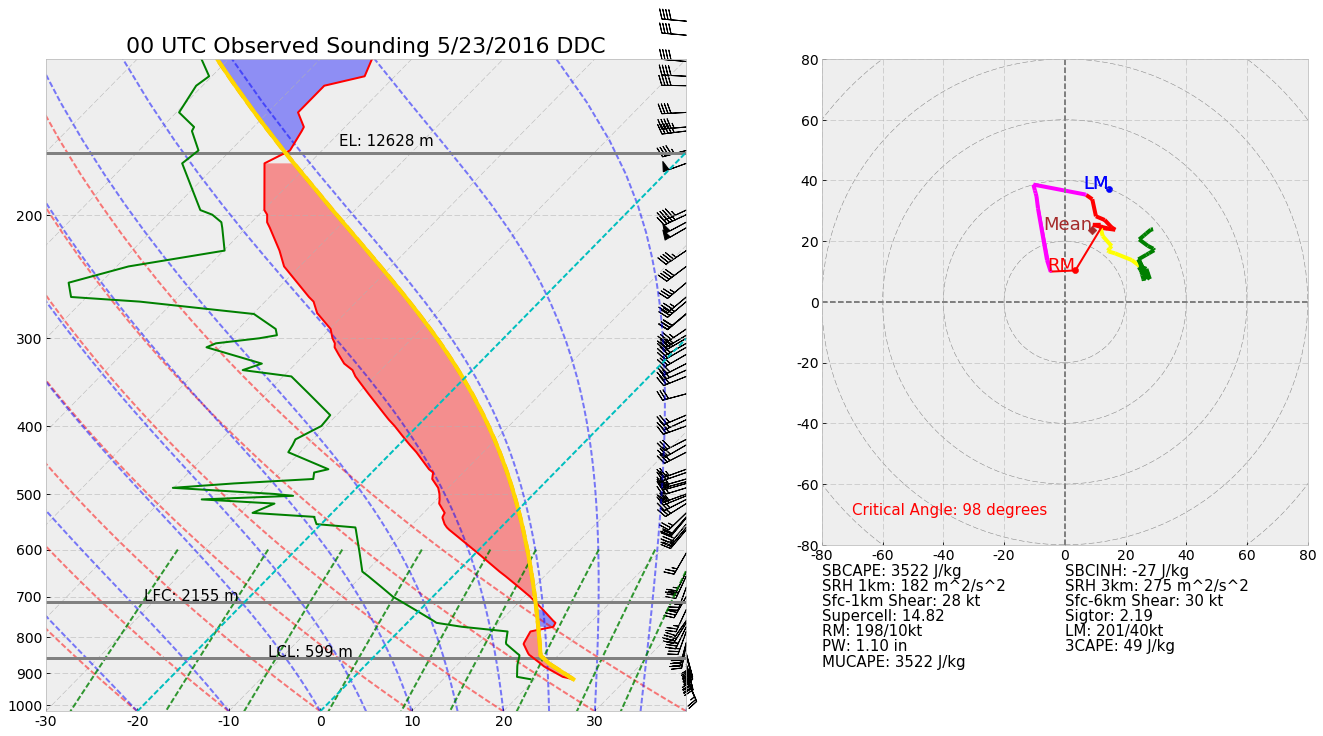

In [73]:
%matplotlib inline
plt.style.use('bmh')
fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(8, 4)
skew = SkewT(fig, rotation=45, subplot=gs[:, :2])

#Add lines for the LCL, LFC, and EL (if they exist)
if np.isnan(LCL_p) == False:
    skew.ax.axhline(LCL_p, color='gray', linewidth = 3)
    plt.text(LCL_t.magnitude - 30, LCL_p.magnitude - 4, "LCL: "+str(int(LCL_h.magnitude-hgt[0].magnitude))+" m", size = 15)

if np.isnan(LFC_p) == False:
    skew.ax.axhline(LFC_p, color='gray', linewidth = 3)
    plt.text(LFC_t.magnitude - 43, LFC_p.magnitude - 4, "LFC: "+str(int(LFC_h.magnitude-hgt[0].magnitude))+" m", size = 15)

if np.isnan(EL_p) == False :
    skew.ax.axhline(EL_p, color='gray', linewidth = 3)
    plt.text(EL_t.magnitude + 5, EL_p.magnitude - 4, "EL: "+str(int(EL_h.magnitude-hgt[0].magnitude))+" m", size = 15)

#if np.isnan(bottom_eff) == False :
#    skew.ax.axhline(levc[bottom_eff], xmin = .05, xmax = .15, color='purple', linewidth = 3)
#    skew.ax.axhline(levc[top_eff], xmin = .05, xmax = .15, color='purple', linewidth = 3)

#Plot temperature, dewpoint, and winds    
skew.plot(levc, Tc, 'r')
skew.plot(levc, Tdc, 'g')
skew.plot_barbs(levc, uc, vc)

#Plot the most unstable parcel path
skew.plot(pres_mu, mu_profile, 'orange', linewidth=4, linestyle = '--')
#Plot the parcel path
skew.plot(levc, prof, 'gold', linewidth=4)


#Let's try to fill between the profile and parcel path.
greater = Tc >= prof
skew.ax.fill_betweenx(levc, Tc, prof, where=greater, facecolor='blue', alpha=0.4)
skew.ax.fill_betweenx(levc, Tc, prof, where=~greater, facecolor='red', alpha=0.4)

#Set bounds and ticklabels for the sounding
skew.ax.set_ylim(1020, 120)
skew.ax.set_xlim(-30, 40)
skew.ax.set_xticklabels([-110,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30], size = 14)
skew.ax.set_yticklabels([100,200,300,400,500,600,700,800,900,1000],size = 14)

#Set up a title
plt.title(UTC+" UTC Observed Sounding "+month+"/"+day+"/"+year+" "+station, size = 22)

#Color the isotherms corresponding to the hail growth zone
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
l2 = skew.ax.axvline(-20, color='c', linestyle='--', linewidth=2)

#Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

#Add the hodograph off to the right of the skew-T
ax1 = fig.add_subplot(gs[:6, 2:])
h = Hodograph(ax1,component_range=80.)
h.add_grid(increment=20)
#Plot winds colored by height on the hodograph
h.plot_layers(uc, vc, hgt, bounds = [0, 1000, 3000, 5000, 10000] * units('meter'),
             colors = ['magenta', 'red', 'yellow', 'green'], linewidth = 4)
#Add the area swept out for sfc-3km SRH and a visualization of the critical angle
h.plot(srh_u, srh_v, color = 'red', linewidth = 2)
h.plot(us500, vs500, color = 'magenta', linewidth = 2)
#Set tick labels for the hodograph
h.ax.set_xticklabels([-80,-60,-40,-20,0,20,40,60,80],size = 14)
h.ax.set_yticklabels([-80,-60,-40,-20,0,20,40,60,80],size = 14)
#Plot storm motions on the hodograph
h.ax.scatter(RM[0].to('knots'), RM[1].to('knots'), s = 38, color = 'r')
h.ax.scatter(LM[0].to('knots'), LM[1].to('knots'), s = 38, color = 'b')
h.ax.scatter(mean_flow[0].to('knots'), mean_flow[1].to('knots'), s = 38, color = 'brown', marker = 'D')
h.ax.text(RM[0].to('knots'), RM[1].to('knots'), "RM", ha = 'right', color = 'r', size = 18)
h.ax.text(LM[0].to('knots'), LM[1].to('knots'), "LM", ha = 'right', color = 'b', size = 18)
h.ax.text(LM[0].to('knots'), LM[1].to('knots'), "LM", ha = 'right', color = 'b', size = 18)
h.ax.text(mean_flow[0].to('knots'), mean_flow[1].to('knots'), "Mean", ha = 'right', color = 'brown', size = 18)

#Add annotations with the values of our convective indices below the hodograph
plt.text(-80, -90, "SBCAPE: "+str(int(cape.magnitude))+" J/kg", size = 15)
plt.text(0, -90, "SBCINH: "+str(int(cin.magnitude))+" J/kg", size = 15)
plt.text(-80, -95, "SRH 1km: "+str(int(srh1[0].magnitude))+" m^2/s^2", size = 15)
plt.text(0, -95, "SRH 3km: "+str(int(srh3[0].magnitude))+" m^2/s^2", size = 15)
plt.text(-80, -100, "Sfc-1km Shear: "+str(int(np.round(shr1[2].to(units.knot).magnitude)))+" kt", size = 15)
plt.text(0, -100, "Sfc-6km Shear: "+str(int(np.round(shr6[2].to(units.knot).magnitude)))+" kt", size = 15)
plt.text(-80, -105, "Supercell: %.2f" %sup_comp, size = 15)
plt.text(0, -105, "Sigtor: %.2f" %sigtor_p, size = 15)
plt.text(-80, -110, "RM: "+str(int(RM_dir.magnitude))+"/"+str(int(RM_spd.magnitude))+"kt", size = 15)
plt.text(0, -110, "LM: "+str(int(LM_dir.magnitude))+"/"+str(int(LM_spd.magnitude))+"kt", size = 15)
plt.text(-80, -115, "PW: %.2f" %pwat.to('inches').magnitude +" in", size = 15)
plt.text(0, -115, "3CAPE: "+str(int(cape3.magnitude))+" J/kg", size = 15)
plt.text(-80, -120, "MUCAPE: "+str(int(mucape.magnitude))+" J/kg", size = 15)
plt.text(-70, -70, "Critical Angle: "+str(int(critical.magnitude))+" degrees", size = 15, color = 'r')
#Optional call to save the figure
plt.savefig("ObservedSounding"+UTC+'UTC'+month+day+year+station+'.png')
#Show the final plot
plt.show()